In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

### Generate synthetic data

In [2]:
from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

N = 10000
M = 30
K = 2
NUM_SPLITS = 3

Ds = [] # data
Xs = [] # features
Ls = [] # noisy labels
Ys = [] # true labels
for _ in range(NUM_SPLITS):
    L, Y, _ = generate_single_task_unipolar(
        N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
        class_balance=[0.3, 0.7], seed=1)
    
    X, D = gaussian_bags_of_words(Y, vocab1k)
    
    Ls.append(L)
    Ys.append(Y)
    Ds.append(D)
    Xs.append(X)

### Apply LabelModel

Overwriting seed=None to seed=2
Overwriting n_epochs=100 to n_epochs=1000
Reaffirming lr=0.01
Overwriting print_at=10 to print_at=100
[Epoch 0] Loss: 435.422895
[Epoch 100] Loss: 0.004350
[Epoch 200] Loss: 0.001577
[Epoch 300] Loss: 0.001421
[Epoch 400] Loss: 0.001322
[Epoch 500] Loss: 0.001171
[Epoch 600] Loss: 0.000922
[Epoch 700] Loss: 0.000642
[Epoch 800] Loss: 0.000472
[Epoch 900] Loss: 0.000413
[Epoch 999] Loss: 0.000396
Finished Training


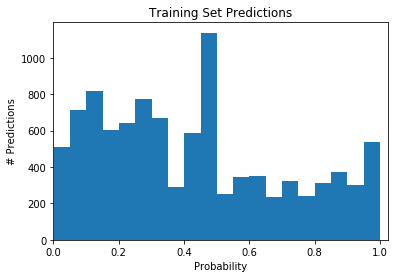

Confusion Matrix (Dev)
        y=1    y=2   
 l=1   2290   1432   
 l=2    768   5510   
Accuracy: 0.778


In [3]:
from metal.label_model import LabelModel

lm = LabelModel(seed=2)
lm.train(Ls[0], L_dev=Ls[1], Y_dev=Ys[1], n_epochs=1000, lr=0.01, print_at=100)
Y_p = lm.score(Ls[1], Ys[1])

In [4]:
Y_p = lm.predict(Ls[1])

### Random Search

In [5]:
search_space = {
    'print_at': 200,
    'n_epochs': 1000, # a single constant value
    'l2': [0, 0.1, 0.01], # a list of discrete values
    'lr': {'range': [0.01, 0.0001], 'scale': 'log'}, # a range and scale to interpolate by
}

In [6]:
from metal.tuner import ModelTuner

tuner = ModelTuner(LabelModel)
init_args = []
train_args = [Ls[0]]
model, best_config = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                  search_space, max_search=5, metric='accuracy')

[1] Testing {'l2': 0.1, 'lr': 0.00014782367342623394}
Overwriting show_plots=True to show_plots=False
[Epoch 0] Loss: 348.311680
[Epoch 200] Loss: 2.112149
[Epoch 400] Loss: 1.095611
[Epoch 600] Loss: 0.789488
[Epoch 800] Loss: 0.671334
[Epoch 999] Loss: 0.624715
Finished Training
Accuracy: 0.590
[2] Testing {'l2': 0.01, 'lr': 0.004884765313390349}
Reaffirming show_plots=False
[Epoch 0] Loss: 310.110048
[Epoch 200] Loss: 0.064544
[Epoch 400] Loss: 0.063798
[Epoch 600] Loss: 0.063600
[Epoch 800] Loss: 0.063457
[Epoch 999] Loss: 0.063329
Finished Training
Accuracy: 0.752
[3] Testing {'l2': 0, 'lr': 0.00018566433578077888}
Reaffirming show_plots=False
[Epoch 0] Loss: 435.422895
[Epoch 200] Loss: 0.824796
[Epoch 400] Loss: 0.282886
[Epoch 600] Loss: 0.124117
[Epoch 800] Loss: 0.059642
[Epoch 999] Loss: 0.031585
Finished Training
Accuracy: 0.683
[4] Testing {'l2': 0.1, 'lr': 0.008167112609961452}
Reaffirming show_plots=False
[Epoch 0] Loss: 193.782519
[Epoch 200] Loss: 0.572848
[Epoch 400] 

### Metrics

Calculate metrics in one of two ways.

1. Use metric_score() and pass the metric name
3. The the specific metric's function (e.g., accuracy_score())

In [7]:
from metal.metrics import metric_score, accuracy_score

metric_score(Ys[1], Y_p, 'accuracy')
accuracy_score(Ys[1], Y_p)

0.7774

0.7774

Built-in metrics include:

In [8]:
metric_score(Ys[1], Y_p, 'accuracy')
metric_score(Ys[1], Y_p, 'coverage')
metric_score(Ys[1], Y_p, 'precision')
metric_score(Ys[1], Y_p, 'recall')
metric_score(Ys[1], Y_p, 'f1')
metric_score(Ys[1], Y_p, 'fbeta', beta=1.0)

0.7774

1.0

0.6119483315392895

0.7436232831916285

0.6713906111603188

0.6713906111603188

### Confusion matrix

In [9]:
from metal.analysis import confusion_matrix
confusion_matrix(Y_p, Ys[1])

array([[2274, 1442],
       [ 784, 5500]])

In [10]:
confusion_matrix(Y_p, Ys[1], normalize=True)

array([[0.2274, 0.1442],
       [0.0784, 0.55  ]])

In [11]:
mat = confusion_matrix(Y_p, Ys[1], pretty_print=True)

        y=1    y=2   
 l=1   2274   1442   
 l=2    784   5500   


### Error analysis

In [12]:
from metal.analysis import error_buckets

buckets = error_buckets(Y_p, Ys[1], Ds[1])
tp = buckets[1,1]

In [13]:
tp[:3]

['congress sound represent wall even none within defense successful suffer commercial same college figure base building around station building level pain national card where subject public president some true foot senior fine try scene structure turn legal within so response mr everybody past process',
 'show detail term remember speech recognize claim artist nature we conference even family every risk amount to entire age speech them whom television better general private director president soldier guy',
 'along win allow win hundred evening call model indeed firm window imagine leave arm of beautiful southern issue result challenge six evening major point weight read final fill half nothing wear choice benefit ok purpose such thing risk rate discussion modern second hotel']

### Label matrix analysis

In [14]:
from metal.analysis import (
    item_coverage,
    item_overlap,
    item_conflict,
    LF_accuracies,
    LF_coverages,
    LF_overlaps,
    LF_conflicts,
)

In [15]:
item_coverage(Ls[0])

0.9096

In [16]:
item_overlap(Ls[0])

0.8243

In [17]:
item_conflict(Ls[0])

0.0

In [18]:
# LF_accuracies(Ls[0], Ys[0])

In [19]:
LF_coverages(Ls[0])

array([0.0436, 0.168 , 0.2098, 0.1786, 0.1884, 0.1478, 0.1878, 0.0792,
       0.0431, 0.2176, 0.243 , 0.0681, 0.0586, 0.2278, 0.0544, 0.0542,
       0.078 , 0.1552, 0.1482, 0.125 , 0.1264, 0.2204, 0.0516, 0.149 ,
       0.0515, 0.1424, 0.0735, 0.0522, 0.067 , 0.2156])

In [20]:
LF_overlaps(Ls[0])

array([0.0378, 0.168 , 0.2098, 0.1786, 0.1884, 0.1478, 0.1878, 0.0718,
       0.038 , 0.2176, 0.243 , 0.0598, 0.0523, 0.2278, 0.0486, 0.0466,
       0.0699, 0.1552, 0.1482, 0.125 , 0.1264, 0.2204, 0.0472, 0.149 ,
       0.0448, 0.1424, 0.0654, 0.0478, 0.0597, 0.2156])

In [21]:
LF_conflicts(Ls[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

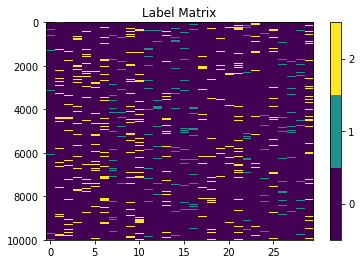

In [22]:
from metal.analysis import (
    view_label_matrix,
    view_overlaps,
    view_conflicts,
)

view_label_matrix(Ls[0])

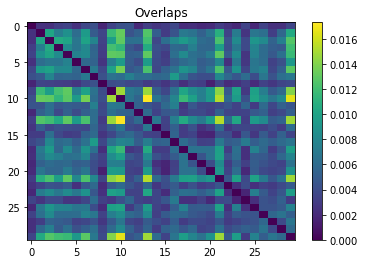

In [23]:
view_overlaps(Ls[0], normalize=True)

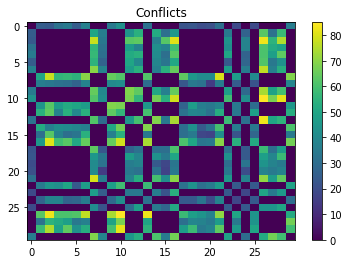

In [24]:
view_conflicts(Ls[0], normalize=False)